# Implementer's Guide: Quickstart

## Objective


The goal of this set of Jupyter notebooks is to introduce users to main classes used in our package. These documents are primarily targeted to implementers, but may also be useful for other users. It also provides some explanations of python, where deemed useful

The generally used API will be denoted by **"""[Public API]"""** in the python code snippets; this is information that any users of the software should generally know, and we should aim to make few changes to that public interface.

Notes to the implementer will be denoated by **"""[Implementer info]"""**; this is information that would ordinarily be abstracted away from users, but that implementers need to know. This info will be subject to rapid change--if this document is failing/seems to be contradicting the code base, please feel free to update it to reflect the latest implementation information!

### Last modified: 2022-08-09

## Table of Contents

0. Example Quickstart
1. Building a circuit (introductions to  Operations, Circuit, CircuitDAG, DAG visualization, openQASM/qiskit visualization, pre-built circuits)
2. Creating a state (QuantumState, StateBase, DensityMatrix, Stabilizer, conversion between states, associated visualizations)
3. Running a circuit (CompilerBase, DensityMatrixCompiler, StabilizerCompiler)
4. Noise models
5. Metrics (MetricBase, Infidelity, TraceDistance, Metrics)
6. Solvers (SolverBase, EvolutionarySolver, DeterministicSolver)
7. Benchmarking
8. (upcoming) Differentiable circuits

Let's get into it!

# Example Quickstart [Public API]

**Premise:** You're inexperienced with quantum circuits, and you want to design two circuits: one which can build a 3 qubit GHZ state. You don't know how to do so manually, so you chose to use the **graph-compiler** solver.

## Using a solver: a Quick Summary

To create a circuit design, we need to be able to:
1. Define your target quantum state.
2. Pick a "compiler", that is, a simulation representation and engine for any circuit you use as a candidate (this allows you to "run" a circuit and see what output it produces).
3. Pick a solver which automatically searches for possible solution circuits (the solver uses the compiler, as well as a "cost function" which will depend on your target and possibly other factors)

## Define a target state

First, we want to express our target states to the compiler.

In [1]:
""" Defining a target state from a density matrix """
import numpy as np

# We can use density matrix functionalities of the graph-compiler
import src.backends.density_matrix.functions as dmf

ghz3_target_dm = dmf.ket2dm(
    (dmf.tensor(3 * [dmf.state_ketz0()]) + dmf.tensor(3 * [dmf.state_ketz1()]))
    / np.sqrt(2)
)

# We express states as QuantumState objects
from src.state import QuantumState

# The argument are: 1) number of qubits in state, 2) the state data (density matrix, here), 3) choice of representation
# If the choice of representation is unspecified, the constructor picks a compatible representation
ghz3_target = QuantumState(3, ghz3_target_dm, representation="density matrix")

**NOTE:** We also have the capabilities to initialize QuantumState objects which use graph or stabilizer representation. However we do not delve further into these capabilities at the moment, because the compiler for these representations (i.e. the simulator) are not fully implemented/tested at this time.

## Define a Compiler

The compiler is the quantum simulation engine of the graph-compiler code. Given a circuit, it will simulate the circuit and output the resulting quantum state.

The `DensityMatrixCompiler` acts on density matrix representation (no misnomer here). It contains the most powerful representation, and can simulate the greatest amount of noise. However, its runtime is exponential in the number of qubit and so it can only handle smaller states. **At time of writing, it is also the best-tested compiler**.

The `StabilizerCompiler` acts on stabilizer representation. It can't represent mixed states, unlike the `DensityMatrixCompiler`, but its runtime is polynomial with the number of qubits.

For this example, we use a `DensityMatrixCompiler`.

In [2]:
""" Define a compiler """
from src.backends.density_matrix.compiler import DensityMatrixCompiler

compiler = DensityMatrixCompiler()
DensityMatrixCompiler.measurement_determinism = 1

# Define a Solver

In the graph-compiler package, the role of the solver is to produce a circuit which creates the "best" circuit, where the circuit is designed to produce the target state (other criteria, such as circuit depth or cost, may also be considered).


For this demonstration, we use a solver called the `EvolutionarySolver`.

In [3]:
""" Defining a Solver (EvolutionarySolver) """

# The evolutionary solver requires a "metric" or "cost function" which tells it
# the quality of a solution circuit. By convention, the evolutionary solver tries to MINIMIZE
# the cost function.
from src.metrics import Infidelity

metric = Infidelity(target=ghz3_target)

# Now that we have a way to evaluate circuit quality, we can define a solver
from src.solvers.evolutionary_solver import EvolutionarySolver

solver = EvolutionarySolver(
    target=ghz3_target,  # target state we want to achieve
    metric=metric,  # how we judge the quality of a solution
    compiler=compiler,  # how we simulate our solution
    n_emitter=1,  # number of emitter qubits available as resources
    n_photon=3,  # number of photons making up the target state
    noise_model_mapping=None,  # we ignore noise in this example
)

C:\Users\julie\Documents\_graduate\git_repositories\graph-compiler\src\solvers\solver_base.py:41: UserWarning: Initial circuit for EvolutionarySolver is 'None'. 
  warnings.warn(f"Initial circuit for {self.__class__.__name__} is 'None'. ")


In [4]:
""" Run your solver """

# Run
solver.seed(0)  # this will allow us to replicate results reliably (fixes the rng)
solver.solve()

Iteration 0 | Best score: 0.7500
Iteration 1 | Best score: 0.7500
Iteration 2 | Best score: 0.7500
Iteration 3 | Best score: 0.7500
Iteration 4 | Best score: 0.7500
Iteration 5 | Best score: 0.5000
Iteration 6 | Best score: 0.5000
Iteration 7 | Best score: 0.5000
Iteration 8 | Best score: 0.5000
Iteration 9 | Best score: 0.5000
Iteration 10 | Best score: 0.5000
Iteration 11 | Best score: 0.5000
Iteration 12 | Best score: 0.5000
Iteration 13 | Best score: 0.5000
Iteration 14 | Best score: 0.5000
Iteration 15 | Best score: 0.5000
Iteration 16 | Best score: 0.5000
Iteration 17 | Best score: 0.5000
Iteration 18 | Best score: 0.5000
Iteration 19 | Best score: 0.5000
Iteration 20 | Best score: 0.5000
Iteration 21 | Best score: 0.5000
Iteration 22 | Best score: 0.5000
Iteration 23 | Best score: 0.5000
Iteration 24 | Best score: 0.5000
Iteration 25 | Best score: 0.5000
Iteration 26 | Best score: 0.5000
Iteration 27 | Best score: 0.5000
Iteration 28 | Best score: 0.5000
Iteration 29 | Best scor

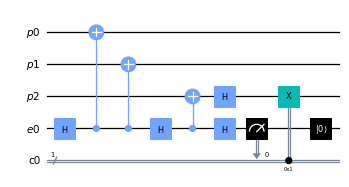

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [5]:
""" Look at solver results """

# The solver has a "hof" (hall of fame) where hof[i][0] is the metric/cost value
# of the i^th best circuit, and hof[i][1] is the i^th best circuit
# We can consider the best circuit...

best_circuit = solver.hof[0][1]
print(best_circuit)

# We can also visualize the generated circuit
best_circuit.draw_circuit()

## Conclusion

We have successfully found a circuit which creates a 3 qubit ghz state! To summarize, we have seen an example of each of the following:
* Defining a target state
* Initializing a compiler
* Initializing a solver metric/cost function
* Running a solver, and getting a solution circuit